In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns
import threading
import os
from scipy import optimize


#plt.style.use('seaborn-deep')
plt.rc('grid', linestyle="--", color='gray')
#plt.rc('xtick', direction = 'in')
#plt.rc('ytick', direction= 'in')
# @working path
FIG_PATH     = '../tex/figs/'
WEB_FIG_PATH = '../tex/web-figs/'
DATA_PATH    = '../code/'

# @global settings
WEB_FIG_DPI  = 600
FIG_DPI      = 800
FIG_EXT      = '.pdf'
WEB_FIG_EXT  = '.png'

# @global functions
def savefig(handler,name, fig_ext = FIG_EXT, web_fig_ext = WEB_FIG_EXT):
    if name != '':
        handler.savefig(FIG_PATH + name + fig_ext, dpi = FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)
    #handler.savefig(WEB_FIG_PATH + name + web_fig_ext, dpi = WEB_FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)

Populating the interactive namespace from numpy and matplotlib


In [2]:
PC     = 648000/np.pi
KPC    = 1000*PC 
AU     = 1
MS     = 1
YR     = 2 * np.pi
Hubble_t = 13.4e9*YR
V_UNIT = 2.9784651272402163E1
KMS    = 1.0/V_UNIT
lc     = 299792.458/V_UNIT
DAY    = YR/365.25636042
HR     = DAY/24
G= 1

In [ ]:
data=np.loadtxt('../code/test/test_ss_0.1_0.5.txt')
p1 = data[:,5:8]
p2 = data[:,15:18]
p3 = data[:,25:28]
dr1 = p2-p1
dr2 = p3-p1
x=0
y=2
t=1000000
plt.scatter(dr1[0:t,x],dr1[0:t,y],s=0.1,lw=0)
plt.scatter(dr2[0:t,x],dr2[0:t,y],s=0.1,lw=0)

In [3]:
ss_idx = {'incident-orbit-s' : 40, 'incident-orbit-e':48, 'post-s':1, 'post-e':32, 'b_max':48, 'v_inf':49}

ss_names = ['s','j', 's1']

ss_pairs = [('s','j'), ('s','s1'), ('s1','j')]


sb_idx = {'incident-orbit-s' : 50, 'incident-orbit-e':58, 'post-s':1, 'post-e':42, 'b_max':66, 'v_inf':67}

sb_names = ['s','j', 's1', 's2']

sb_pairs = [('s','j'), ('s','s1'),('s','s2'), ('s1','j'),('s2','j'),('s1','s2')]



bs_idx = {'incident-orbit-s' : 50, 'incident-orbit-e':58, 'post-s':1, 'post-e':42, 'b_max':66, 'v_inf':67}

bs_names = ['s','sb', 'j', 's1']

bs_pairs = [('s','j'), ('s','s1'),('s','sb'), ('s1','j'),('sb','j'),('s1','sb')]



bb_idx = {'incident-orbit-s' : 60, 'incident-orbit-e':68, 'post-s':1, 'post-e':52, 'b_max':84, 'v_inf':85}

bb_names = ['s','sb', 'j', 's1','s2']

bb_pairs = [('s','j'), ('s','s1'),('s','sb'), ('s1','j'),('sb','j'),('sb','s1'),('s','s2'),('s2','j'),('s1','s2'),('sb','s2')]

In [ ]:
def cross(ms, mj, aj, v):
    return 3306*ms*mj*aj*v**(-2)

den = 100.                                    
vel = np.linspace(0.1,30,100)                                                                            
t_Hub = 3.1e7*14.e9

uAU = 1.49e13

aj = 1.                                                                           

rate = 3306./3.1e18*uAU/3.1e18*uAU*t_Hub/3.1e18*vel**(-2.)*aj *  vel*1e5 * 0.1

den=[1, 100, 1e5]
colors = cm.viridis(np.linspace(0.2,0.8,len(den)))
fig=plt.figure(figsize=(4,3))
for d,c in zip(den,colors):
    plt.plot(vel,rate*d,label='$n=10^{' +'%.1d'%np.log10(d)+'}PC^{-3}$',color=c)
plt.yscale('log')
plt.legend()
plt.xlabel('$v_\infty$ [$kms^{-1}$]')
plt.ylabel('$\Gamma_{ex}[\\tau_{Hublle}^{-1}]$')
plt.grid(True)
savefig(plt,'letter-rate')

In [ ]:
den = 100.                                    
vel = 10                                                                           
t_Hub = 3.1e7*14.e9

AU = 1.49e13

aj = 5.                                                                           

rate = 3306./3.1e18*AU/3.1e18*AU*t_Hub/3.1e18*den*vel**(-2.)*aj *  vel*1e5
print(rate)

In [6]:
def load_orbit(data,orbit_name):
    name = ['m1', 'm2', 'p', 'e', 'i', 'Omega', 'omega', 'nv']
    orbit={}
    for key, i in zip(name, range(len(name))):
        orbit.update({orbit_name+key : data[:,i]})
    return orbit

def load_incid_args(data):
    return {'v_inf': data[:,0], 'b':data[:,1], 'w':data[:,2], 'ii':data[:,3],'iphi':data[:,4]}

def load_post_scattered(data, obj_name):
    dic = {'time':data[:,0]}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 10*idx
        dic.update({'m_{' + name + '}': data[:,offset + 3],
                    'r_{' + name + '}': data[:,offset + 4],
                    'px_{' + name + '}': data[:,offset + 5],
                    'py_{' + name + '}': data[:,offset + 6],
                    'pz_{' + name + '}': data[:,offset + 7],
                    'vx_{' + name + '}': data[:,offset + 8],
                    'vy_{' + name + '}': data[:,offset + 9],
                    'vz_{' + name + '}': data[:,offset + 10]
                   })
    return dic
        
def load_closest(data, obj_name):
    dic ={}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 6*idx
        dic.update({'closest:px_{' + name + '}': data[:,offset + 0],
                    'closest:py_{' + name + '}': data[:,offset + 1],
                    'closest:pz_{' + name + '}': data[:,offset + 2],
                    'closest:vx_{' + name + '}': data[:,offset + 3],
                    'closest:vy_{' + name + '}': data[:,offset + 4],
                    'closest:vz_{' + name + '}': data[:,offset + 5]})
    return dic
        
def load_data(fname, os, objname):
    data = np.loadtxt(fname)
    
    dic = {}
    dic.update(load_orbit(data[:,os['incident-orbit-s']:os['incident-orbit-e']],'incident-orbit-') )
    dic.update(load_orbit(data[:,os['post-e']:os['post-e']+8],'planet-orbit-') )
    #dic.update(load_incid_args(data[:,os['incident-s']:os['incident-e']]))
    
    dic.update(load_post_scattered(data[:,os['post-s']:os['post-e']], objname))
    
    if 'closest-s' and 'closest-e' in os:
        dic.update(load_closest(data[:,os['closest-s']:os['closest-e']], objname))
    
    if 'sn-orbit-s' and 'sn-orbit-e' in os:
        dic.update(load_orbit(data[:,os['sn-orbit-s']:os['sn-orbit-e']],'sn-orbit-'))
        
    if 'ss-orbit-s' and 'ss-orbit-e' in os:
        dic.update(load_orbit(data[:,os['ss-orbit-s']:os['ss-orbit-e']],'ss-orbit-'))

    l,w = data.shape

    if 'b_max' in os and os['b_max']<w:
        dic.update({'b_max': data[:, os['b_max'] ]})
        
    if 'v_inf' in os and os['v_inf']<w:
        dic.update({'v_inf': data[:, os['v_inf']]})
    return dic


def get_a_e(m, drx, dry, drz, dvx, dvy, dvz):
    r  = np.sqrt(drx**2 + dry**2 + drz**2)
    v2 = dvx**2 + dvy**2 + dvz**2
    v  = np.sqrt(v2)
    
    vrdot = drx*dvx + dry*dvy + drz*dvz
    
    vdfsq = (v2 - m / r)
    ex = (vdfsq * drx - vrdot * dvx)
    ey = (vdfsq * dry - vrdot * dvy) 
    ez = (vdfsq * drz - vrdot * dvz) 
    e  = np.sqrt(ex * ex + ey * ey + ez * ez) / m
    a  = -m / (v2 - 2 * m/r)
    return a, e


def calc_pair_a_e(data, pairs):
    dic = {}
    for name_i, name_j in pairs:
        mi = data['m_{' + name_i + '}']
        mj = data['m_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        dvx = data['vx_{' + name_i + '}'] - data['vx_{' + name_j + '}']
        dvy = data['vy_{' + name_i + '}'] - data['vy_{' + name_j + '}']
        dvz = data['vz_{' + name_i + '}'] - data['vz_{' + name_j + '}']
        

        a, e = get_a_e(mi + mj, dpx, dpy, dpz, dvx, dvy, dvz)
        dic.update({'a_{' + name_i + ',' + name_j + '}': a,  'e_{' + name_i + ',' + name_j + '}': e})
    return dic
        
def calc_tidal_t_scale(data, star_name, planet_name='j'):
    mp = data['m_{'+planet_name+ '}']
    rp = data['r_{'+planet_name+ '}']
    dic = {}
    for name in star_name:
        rs = data['r_{' + name + '}']
        ms = data['m_{' + name + '}']
        #s = 9.0/4/2e7*mp/ms*rs**5
        p = 9.0/4/2.5e4*ms/mp*rp**5
        a = data['a_{' + name + ',' + planet_name + '}']
        e = data['e_{' + name + ',' + planet_name + '}']
        n = np.sqrt( G*(ms+mp)/a**3)
        tau_ap = 3/n*a**5/14/e**2/p
        dic.update({'T_{' + name + ',' + planet_name + '}' : tau_ap})
    return dic

def check_collision(data, pairs):
    dic ={}
    for name_i, name_j in pairs:
        ri = data['r_{' + name_i + '}']
        rj = data['r_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        
        coll = np.sqrt(dpx**2 + dpy**2 + dpz**2) <= (ri + rj)
        
        
        data['star outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        data['planet outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        #dic.update({'coll_{' + name_i + ',' + name_j + '}': coll})
    #return dic

def classify_star_outcome(data, star_pairs):
    init_bound = np.ones(data['time'].shape, dtype=bool)
    init_unbound =np.ones(data['time'].shape, dtype=bool)
    disrupted = np.zeros(data['time'].shape, dtype=bool)
    
    for name_i, name_j in star_pairs:
        if (name_i == 's1') and (name_j == 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            init_bound = init_bound & bound
            init_unbound=init_unbound&unbound
            disrupted = np.ones(data['time'].shape, dtype=bool)
    
    
    flyby = np.ones(data['time'].shape, dtype=bool)
    
    bi_formation ={}
    for name_i, name_j in star_pairs:
        if (name_i != 's1') or (name_j != 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            
            bi_formation.update({'reunion_{' + name_i + ',' + name_j + '}': bound & init_unbound})
        
            flyby = flyby & unbound & init_bound
            
            disrupted = disrupted & unbound & init_unbound
        
    reunion = np.zeros(data['time'].shape, dtype=bool)
    for key, r in bi_formation.items():
        reunion = reunion | r
        
    data['star outcome'][reunion] = 'reunion'
    data['star outcome'][flyby]  = 'flyby'
    data['star outcome'][disrupted] = 'disrupted'
    
    #dic = {'reunion':reunion, 'flyby' : flyby, 'disrupted': disrupted}
    
    #dic.update(bi_formation)
            
    #return dic

def classify_planet_outcome(data, star_names, planet_name='j', a_final=0.1*AU):
    binary = []
    for star_name in star_names:
        a = data['a_{' + star_name + ',' + planet_name + '}']
        e = data['e_{' + star_name + ',' + planet_name + '}']
        tau_ap = data['T_{' + star_name + ',' + planet_name + '}']
        
        bound = (a > 0) & (0 <=e) & (e < 1)
        unbound = (e >= 1) & (a <= 0) 
        hot_jupiter_candi = (a*(1-e*e) < a_final) & (tau_ap < Hubble_t) 
        binary.append((star_name, bound, unbound, hot_jupiter_candi))
        
    dic={}
    for star_name1, bound1, unbound1, hj1 in binary:
        bound = bound1
        hot_jupiter = hj1
        for star_name2, bound2, unbound2, hj2 in binary:
            if(star_name1 != star_name2):
                bound = bound & unbound2
                hot_jupiter = hot_jupiter & unbound2
                
        data['planet outcome'][bound] = 'stay_{' + star_name1 + ',' + planet_name + '}'
        data['planet outcome'][hot_jupiter] = 'HJ_{' + star_name1 + ',' + planet_name + '}' 
    
        #dic.update({'stay_{' + star_name1 + ',' + planet_name + '}' : bound, 'HJ_{' + star_name1 + ',' + planet_name + '}' : hot_jupiter})
        
    ejection = np.ones(data['time'].shape, dtype=bool)
    for star_name, bound, unbound, hj in binary:
        ejection = ejection & unbound
        
    data['planet outcome'][ejection] = 'ejection_{'+planet_name+'}'
    
    
def post_process(fname, oss, objname, pairs):
    star_name = [ name for name in objname if name.startswith('s')]
    planet_name = [ name for name in objname if not name.startswith('s')]
    star_pairs = [(s1, s2) for s1, s2 in pairs if s1.startswith('s') and s2.startswith('s')]
    
    #print(star_name, planet_name, star_pairs)
    
    if os.path.exists(fname) == False:
        print('no such a file'+fname)
        return
    
    data = load_data(fname, oss, objname)
    
    data.update({'star outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update({'planet outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update(calc_pair_a_e(data, pairs))
    
    classify_star_outcome(data, star_pairs)
   
    
    for p_name in planet_name:
        data.update(calc_tidal_t_scale(data, star_name, p_name))
        classify_planet_outcome(data, star_name, p_name)
        
    check_collision(data, pairs)
    
    return data

def get_ss_final_data(df, v_inf, aj):
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}')
    
    stay = pfate == 'stay_{s,j}'
    capture = pfate == 'stay_{s1,j}'
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, capture.sum()/ntot

def get_sb_final_data(df, v_inf, aj):
    
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,s2}' ) | (sfate== 'coll_{s1,s2}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{s2,j}')
    
    stay = pfate == 'stay_{s,j}'
    
    s_capture = ( (pfate == 'stay_{s1,j}') & (sfate == 'disrupted') ) | ( (pfate == 'stay_{s2,j}') & (sfate == 'disrupted') )
    
    b_capture = ( (pfate == 'stay_{s1,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') )) | ( (pfate == 'stay_{s2,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') ))
    
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, s_capture.sum()/ntot, b_capture.sum()/ntot
    
def get_bs_final_data(df, v_inf, aj):
    
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,sb}' ) | (sfate== 'coll_{s1,sb}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{sb,j}')
    
    stay = pfate == 'stay_{s,j}'
    
    capture = pfate == 'stay_{s1,j}'
    
    trans = pfate == 'stay_{sb,j}'
    
    print('here')
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, capture.sum()/ntot, trans.sum()/ntot

def get_bb_final_data(df, v_inf, aj):
    
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,s2}' ) | (sfate== 'coll_{s1,s2}' ) | (sfate== 'coll_{s,sb}' ) | (sfate== 'coll_{sb,s1}' )| (sfate== 'coll_{sb,s2}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{s2,j}')
    
    stay = pfate == 'stay_{s,j}'
    
    s_capture = ( (pfate == 'stay_{s1,j}') & (sfate == 'disrupted') ) | ( (pfate == 'stay_{s2,j}') & (sfate == 'disrupted') )
    
    b_capture = ( (pfate == 'stay_{s1,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') )) | ( (pfate == 'stay_{s2,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') ))
    
    trans = pfate == 'stay_{sb,j}'
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, s_capture.sum()/ntot, b_capture.sum()/ntot, trans.sum()/ntot

In [ ]:
import csv
def write_list_to_file(data, filename):
    """Write the list to csv file."""
    with open(filename,'w') as out:
        csv_out=csv.writer(out)
        #csv_out.writerow(['name','num'])
        for row in data:
            csv_out.writerow(row)

In [ ]:
v=np.array([0.1, 3.42222222,  6.74444444,  10.06666667, 13.38888889, 16.71111111, 20.03333333, 23.35555556, 26.67777778, 30])

v_name =['0.1', '3.4', '6.7', '10.1', '13.4', '16.7', '20.0', '23.4', '26.7', '30.0']
a_j = ['0.1', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']

In [49]:
#prefix = '../code/solar-normal/bb/solar-normal-bb_bb_'
#prefix = '../code/ss/solar-normal-ss_ss_'
prefix = '../code/ueq/ueq-normal-ss_ss_'
vel = '0.1'
idx = ss_idx
names = ss_names
pairs = ss_pairs

#df01 = pd.DataFrame(post_process(prefix+ vel+ '_0.1.txt', idx, names, pairs))

df05 = pd.DataFrame(post_process(prefix+ vel+ '_0.5.txt', idx, names, pairs))

df1 = pd.DataFrame(post_process(prefix+ vel+ '_1.0.txt', idx, names, pairs))

df2 = pd.DataFrame(post_process(prefix+ vel+'_2.0.txt', idx, names, pairs))

df5 = pd.DataFrame(post_process(prefix+ vel+'_5.0.txt', idx, names, pairs))

/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in less


KeyboardInterrupt: 

In [ ]:
prefix11 = '../code/ss/solar-normal-ss_ss_'
prefix21 = '../code/solar-normal/sb/solar-normal-sb_sb_'
prefix12 = '../code/solar-normal/bs/solar-normal-bs_bs_'
prefix22 = '../code/solar-normal/bb/solar-normal-bb_bb_'

prefix_pure21 = '../code/pure/sb/solar-normal-sb_sb_'
prefix_pure22 = '../code/pure/bb/solar-normal-bb_bb_'
#prefix = '../code/ss/solar-normal-ss_ss_'

vel = '3.'

df11 = pd.DataFrame(post_process(prefix11+ vel+ '_1.0.txt', ss_idx, ss_names, ss_pairs))

df21 = pd.DataFrame(post_process(prefix21+ vel+ '_1.0.txt', sb_idx, sb_names, sb_pairs))

df12 = pd.DataFrame(post_process(prefix12+ vel+ '_1.0.txt', bs_idx, bs_names, bs_pairs))
    
df22 = pd.DataFrame(post_process(prefix22+ vel+ '_1.0.txt', bb_idx, bb_names, bb_pairs))


In [ ]:
psb_idx = {'incident-orbit-s' : 32, 'incident-orbit-e':40, 'post-s':1, 'post-e':32}

psb_names = ['s', 's1', 's2']

psb_pairs = [ ('s','s1'),('s','s2'),('s1','s2')]



pbb_idx = {'incident-orbit-s' : 42, 'incident-orbit-e':50, 'post-s':1, 'post-e':42}

pbb_names = ['s','sb', 's1','s2']

pbb_pairs = [ ('s','s1'),('s','sb'),('sb','s1'),('s','s2'),('s1','s2'),('sb','s2')]


df_pure_21 = pd.DataFrame(post_process(prefix_pure21+ vel+ '_1.0.txt', psb_idx, psb_names, psb_pairs))

df_pure_22 = pd.DataFrame(post_process(prefix_pure22+ vel+ '_1.0.txt', pbb_idx, pbb_names, pbb_pairs))

In [ ]:
from scipy import stats

def get_post_a(df,suffix):
    a = df['a_'+suffix]
    e = df['e_'+suffix]
    mask = (a>0)&(0<=e)&(e<1)

    return a[mask], e[mask]


def draw_axis(ax, df, tp):
    colors = cm.viridis(np.linspace(0,1,len(tp)))
    for t,c in zip(tp,colors):
        a , e = get_post_a(df, t)
        ax.scatter(np.log10(a), e, label=t,lw=0,s=0.5)

def draw_axis_dist(ax, df, tp,ls='-'):
    colors = cm.viridis(np.linspace(0,1,len(tp)))
    for t,c in zip(tp,colors):
        a , e = get_post_a(df, t)
        ax.hist((a[a<50]),bins='auto', histtype='step',alpha=1,label=t,density=True,ls=ls)

def draw_e_dist(ax, df, tp,ls='-'):
    colors = cm.viridis(np.linspace(0,1,len(tp)))
    for t,c in zip(tp,colors):
        a , e = get_post_a(df, t)
        ax.hist(e,bins='auto', histtype='step',alpha=1,label=t,density=True,ls=ls)

def draw_all_axis(df11, df12, df21, df22):
    fig= plt.figure(figsize=(8,6))
    ax= fig.add_subplot(2,2,1)
    draw_axis(ax, df11, ['{s,s1}'])

    ax= fig.add_subplot(2,2,2)
    draw_axis(ax, df12, ['{s,s1}','{s,sb}','{s1,sb}'])


    ax= fig.add_subplot(2,2,3)
    draw_axis(ax, df21, ['{s,s1}','{s,s2}','{s1,s2}'])


    ax= fig.add_subplot(2,2,4)
    draw_axis(ax, df22, ['{s,s1}','{s,sb}','{sb,s1}','{s,s2}','{s1,s2}','{sb,s2}'])

    plt.tight_layout()

#draw_all_axis(df11, df12, df21, df22)

def draw_compare(df21,df22, df_pure21, df_pure22):
    sb_pair = ['{s,s1}']# ['{s,s1}','{s,s2}','{s1,s2}']
    bb_pair = ['{s,s1}'] #['{s,s1}','{s,sb}','{sb,s1}','{s,s2}','{s1,s2}','{sb,s2}']
    fig= plt.figure(figsize=(8,6))
    ax= fig.add_subplot(2,2,1)
    draw_axis_dist(ax, df21, sb_pair)
    draw_axis_dist(ax, df_pure21, sb_pair,'--')
    ax.legend()
    ax.set_xlabel('$\log_{10}(a/AU)$')
    #ax.set_yscale('log')


    ax= fig.add_subplot(2,2,2)
    draw_axis_dist(ax, df22, bb_pair)
    draw_axis_dist(ax, df_pure22, bb_pair,'--')
    ax.legend()
    ax.set_xlabel('$\log_{10}(a/AU)$')
    #ax.set_yscale('log')


    ax= fig.add_subplot(2,2,3)
    draw_e_dist(ax, df21, sb_pair)
    draw_e_dist(ax, df_pure21, sb_pair,'--')
    ax.legend()
    ax.set_xlabel('$e$')


    ax= fig.add_subplot(2,2,4)
    draw_e_dist(ax, df22, bb_pair)
    draw_e_dist(ax, df_pure22, bb_pair,'--')
    ax.legend()
    ax.set_xlabel('$e$')

    plt.tight_layout()
    savefig(plt,'pure_star_cmp')
draw_compare(df21,df22, df_pure_21, df_pure_22)

In [ ]:
def min_a(a1,a2):
    ep1 = a1 > 0
    ep2 = a2 > 0
    (a1 < a2) & (a2)

def flyby_a(df,tp):
    if tp == 'ss':
        return df['a_{s,s1}']
    elif tp == 'sb':
        return df['a_{s1,s2}']
    elif tp == 'bs':
        return df['a_{sb,s1}']
    elif tp == 'bb':
        return df['a_{s1,s2}']

def get_cm(key, df, tp):
    ms = df['m_{s}']
    ms1= df['m_{s1}']

    xs = df[key+'x_{s}']
    ys = df[key+'y_{s}']
    zs = df[key+'z_{s}']

    xs1 = df[key+'x_{s1}']
    ys1 = df[key+'y_{s1}']
    zs1 = df[key+'z_{s1}']

    if tp == 'ss':
        m_tot = ms + ms1
        cmx = (xs*ms + xs1*ms1)/m_tot
        cmy = (ys*ms + ys1*ms1)/m_tot
        cmz = (zs*ms + zs1*ms1)/m_tot

        return m_tot, cmx, cmy, cmz
    elif tp == 'sb':
        
        ms2 = df['m_{s2}']
        xs2 = df[key+'x_{s2}']
        ys2 = df[key+'y_{s2}']
        zs2 = df[key+'z_{s2}']
        m_tot = ms+ms1+ms2

        cmx = (xs*ms + xs1*ms1 + xs2*ms2)/m_tot
        cmy = (ys*ms + ys1*ms1 + ys2*ms2)/m_tot
        cmz = (zs*ms + zs1*ms1 + zs2*ms2)/m_tot

        return m_tot, cmx, cmy, cmz
    elif tp == 'bs':
        mb = df['m_{sb}']
        xsb = df[key+'x_{sb}']
        ysb = df[key+'y_{sb}']
        zsb = df[key+'z_{sb}']

        m_tot = ms+ms1+mb

        cmx = (xs*ms + xs1*ms1 + xsb*mb)/m_tot
        cmy = (ys*ms + ys1*ms1 + ysb*mb)/m_tot
        cmz = (zs*ms + zs1*ms1 + zsb*mb)/m_tot

        return m_tot, cmx, cmy, cmz
    elif tp == 'bb':
        ms2 = df['m_{s2}']
        xs2 = df[key+'x_{s2}']
        ys2 = df[key+'y_{s2}']
        zs2 = df[key+'z_{s2}']

        mb = df['m_{sb}']
        xsb = df[key+'x_{sb}']
        ysb = df[key+'y_{sb}']
        zsb = df[key+'z_{sb}']

        m_tot = ms+ms1+mb+ms2

        cmx = (xs*ms + xs1*ms1 + xsb*mb + xs2*ms2)/m_tot
        cmy = (ys*ms + ys1*ms1 + ysb*mb + ys2*ms2)/m_tot
        cmz = (zs*ms + zs1*ms1 + zsb*mb + zs2*ms2)/m_tot

        return m_tot, cmx, cmy, cmz

def get_Ep(df, tp):
    def E_p(m1, m2, x1, y1, z1, x2, y2, z2):
        dx = x1 - x2
        dy = y1 - y2
        dz = z1 - zs
        dr = np.sqrt(dx**2 + dy**2 + dz**2)
        return -m1*m2/dr

    def E_k(m, vx, vy, vz):
        return 0.5*m*(vx**2 + vy**2 + vz**2)

    mj = df['m_{j}']
    ms = df['m_{s}']
    ms1= df['m_{s1}']

    xj = df['px_{j}']
    yj = df['py_{j}']
    zj = df['pz_{j}']

    xs = df['px_{s}']
    ys = df['py_{s}']
    zs = df['pz_{s}']

    xs1 = df['px_{s1}']
    ys1 = df['py_{s1}']
    zs1 = df['pz_{s1}']

    xvs = df['vx_{s}']
    yvs = df['vy_{s}']
    zvs = df['vz_{s}']

    xvs1 = df['vx_{s1}']
    yvs1 = df['vy_{s1}']
    zvs1 = df['vz_{s1}']

    Ep = E_p(mj, ms, xj, yj, zj, xs, ys, zs) + E_p(mj, ms1, xj, yj, zj, xs1, ys1, zs1)

    Ek = E_k(ms, xvs, yvs, zvs) + E_k(ms1, xvs1, yvs1, zvs1)

    if tp == 'sb':
        ms2 = df['m_{s2}']
        xs2 = df['px_{s2}']
        ys2 = df['py_{s2}']
        zs2 = df['pz_{s2}']
        xvs2 = df['vx_{s2}']
        yvs2 = df['vy_{s2}']
        zvs2 = df['vz_{s2}']
        
        Ep += E_p(mj, ms2, xj, yj, zj, xs2, ys2, zs2)
        Ek += E_k(ms2, xvs2, yvs2, zvs2)

    elif tp == 'bs':
        mb = df['m_{sb}']
        xsb = df['px_{sb}']
        ysb = df['py_{sb}']
        zsb = df['pz_{sb}']
        xvsb = df['vx_{sb}']
        yvsb = df['vy_{sb}']
        zvsb = df['vz_{sb}']

        Ep += E_p(mj, mb, xj, yj, zj, xsb, ysb, zsb)
        Ek += E_k(mb, xvsb, yvsb, zvsb)
        
    elif tp == 'bb':
        ms2 = df['m_{s2}']
        xs2 = df['px_{s2}']
        ys2 = df['py_{s2}']
        zs2 = df['pz_{s2}']
        xvs2 = df['vx_{s2}']
        yvs2 = df['vy_{s2}']
        zvs2 = df['vz_{s2}']

        mb = df['m_{sb}']
        xsb = df['px_{sb}']
        ysb = df['py_{sb}']
        zsb = df['pz_{sb}']
        xvsb = df['vx_{sb}']
        yvsb = df['vy_{sb}']
        zvsb = df['vz_{sb}']

        Ep += E_p(mj, ms2, xj, yj, zj, xs2, ys2, zs2)
        Ep += E_p(mj, mb, xj, yj, zj, xsb, ysb, zsb)
        Ek += E_k(ms2, xvs2, yvs2, zvs2)
        Ek += E_k(mb, xvsb, yvsb, zvsb)

    return 2*Ep 
        

def get_v_inf(df, tp):
    
    mj = df['m_{j}']

    vxj = df['vx_{j}']
    vyj = df['vy_{j}']
    vzj = df['vz_{j}']

    vj = np.sqrt(vxj**2 + vyj**2 + vzj**2)

    pxj = df['px_{j}']
    pyj = df['py_{j}']
    pzj = df['pz_{j}']

    m_tot, pcmx, pcmy, pcmz = get_cm('p', df, tp)

    m_tot, vcmx, vcmy, vcmz = get_cm('v', df, tp)

    vcm = np.sqrt(vcmx**2 + vcmy**2 + vcmz**2)

    dx = pcmx - pxj
    dy = pcmy - pyj
    dz = pcmz - pzj
    dr = np.sqrt(dx**2 + dy**2 + dz**2)

    dvx = vcmx - vxj
    dvy = vcmy - vyj
    dvz = vcmz - vzj
    dv = np.sqrt(dx**2 + dy**2 + dz**2)

    E = 0.5*mj*vj**2 + 0.5*m_tot*vcm**2 + get_Ep(df, tp)  #- mj*m_tot/dr

    v_inf = np.sqrt(2*E*m_tot/mj/(m_tot+mj))

    return v_inf, dr

def get_dist(df,k1,k2):
    x1 = df['px_{'+k1+'}']
    y1 = df['py_{'+k1+'}']
    z1 = df['pz_{'+k1+'}']

    x2 = df['px_{'+k2+'}']
    y2 = df['py_{'+k2+'}']
    z2 = df['pz_{'+k2+'}']

    dx = x1 - x2
    dy = y1 - y2
    dz = z1 - z2

    r1 = df['r_{'+k1+'}']
    r2 = df['r_{'+k2+'}']

    return np.sqrt(dx**2 + dy**2 + dz**2), r1+r2

def ejection_v(dfs, a0s, tp,colors):
    fig = plt.figure(figsize=(4,3))
    for df, a0, color in zip(dfs, a0s, colors):
        v0 = np.sqrt(1/a0)

        vj,dr = get_v_inf(df,tp)

        defined = (df['star outcome'] != 0 ) & (df['planet outcome'] != 0)

        coll = (df['planet outcome'] ==  'coll_{s1,j}') | (df['planet outcome'] ==  'coll_{s,j}') | (df['planet outcome'] ==  'coll_{sb,j}') #ejection_{j}') & defined 

        flyby = df['star outcome'] ==  'flyby'

        ej = (df['planet outcome'] ==  'ejection_{j}') & defined  

        #a = get_tightest_a(df, tp)
        
        #t = df['time']

        #r , d = get_dist(df,'j','s')

        #r1 , d1 = get_dist(df,'j','s1')

        #r2 , d2 = get_dist(df,'j','sb')

        #rmin = r
        #rmin[r1 < rmin] = r1[r1 < rmin]
        #rmin[r2 < rmin] = r2[r2<rmin]

        #ultr = (vj[ej]/v0 > 10 ) & ej
        


        #plt.hist(df['star outcome'][ultra])

        #return

        #a = flyby_a(df, tp)
        
        #plt.hist(a[ej])
        #plt.hist(np.log10(rmin[ej]))

        #plt.axvline(np.log10(d.mean()))

        #plt.axvline(np.log10(d1.mean()))

        #plt.axvline(np.log10(d2.mean()))

        #return
        #if a0 != 2:
        #    continue
        
        #plt.scatter(np.log10(vj[ej]/KMS), (rmin[ej]),s=.5,color=color,lw=0,label='$a_p$='+str(a0)+'AU')

        #plt.axhline(d.mean(),ls='--',lw=0.5,label='collision limit')
    
        #plt.yscale('log')

        #return

        #plt.hist(np.log10(vj[coll]/KMS),bins='auto',histtype='step',density=True,color=color,ls='-')

        #plt.scatter(np.log10(vj[ej&flyby]/KMS),(a[ej&flyby]/KMS),s=1,color=color,label='$a_p$='+str(a0)+'AU')
        plt.hist(np.log10(vj[ej]/KMS),bins='auto',histtype='step',density=True,color=color,ls='-')
        plt.hist(np.log10(vj[ej]/KMS),bins='auto',histtype='stepfilled',density=True,color=color,alpha=0.3,label='$a_{\\rm p}$='+str(a0)+'AU')

        #plt.hist(np.log10(vj[ej&~flyby]/KMS),bins='auto',histtype='step',density=True,color=color,ls='--')
        #plt.hist(np.log10(vj[ej&~flyby]/KMS),bins='auto',histtype='stepfilled',density=True,color=color,alpha=0.3,label='$a_p$='+str(a0)+'AU')

        plt.axvline(np.log10(v0/KMS),color=color,ls='--',label='$v_{\\rm p}($'+str(a0)+'AU)')

        #return
    plt.legend(loc=2,frameon=False)
    plt.xlabel('$\log_{10}(v_{\\rm ej}/$km s$^{-1})$')

    #plt.ylabel('min(d) [AU]')
    plt.ylabel('PDF')
    #plt.grid(True)
    savefig(plt,'ejection-v-sb-01')
    #savefig(plt, 'investigation')
ejection_v([df05, df1, df2, df5], [0.5,1,2,5], 'sb', cm.viridis(np.linspace(0,1,4)))

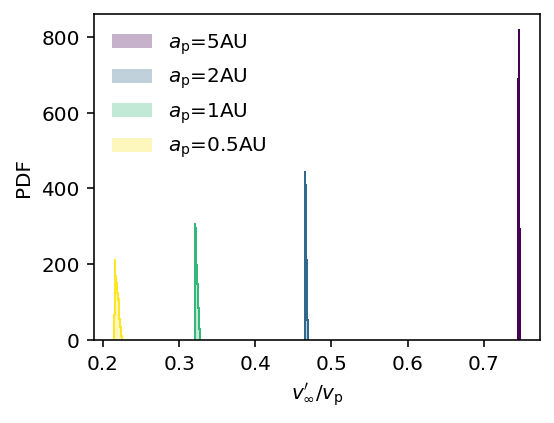

In [29]:
def v_hist(dfs,a0s):
    colors = cm.viridis(np.linspace(0,1,len(dfs)))
    fig=plt.figure(figsize=(4,3))
    

    for df, a0, color in zip(dfs,a0s,colors):
        cap = df['planet outcome'] == 'stay_{s1,j}'

        ms1 = np.array(df['m_{s1}'])
        ms = np.array(df['m_{s}'])
        mj = np.array(df['m_{j}'])
        
        vxs1 = np.array(df['vx_{s1}'])
        vys1 = np.array(df['vy_{s1}'])
        vzs1 = np.array(df['vz_{s1}'])

        vxs = np.array(df['vx_{s}'])
        vys = np.array(df['vy_{s}'])
        vzs = np.array(df['vz_{s}'])
        
        vxj = np.array(df['vx_{j}'])
        vyj = np.array(df['vy_{j}'])
        vzj = np.array(df['vz_{j}'])
        
        vxcm = (vxs1*ms1 + vxj*mj)/(ms1+mj) 
        vycm = (vys1*ms1 + vyj*mj)/(ms1+mj) 
        vzcm = (vzs1*ms1 + vzj*mj)/(ms1+mj) 

        vs = np.sqrt(vxs**2 + vys**2 + vzs**2)
        
        vcm = np.sqrt(vxcm**2 + vycm**2 + vzcm**2)

        pxs1 = np.array(df['px_{s1}'])
        pys1 = np.array(df['py_{s1}'])
        pzs1 = np.array(df['pz_{s1}'])

        pxs = np.array(df['px_{s}'])
        pys = np.array(df['py_{s}'])
        pzs = np.array(df['pz_{s}'])
        
        pxj = np.array(df['px_{j}'])
        pyj = np.array(df['py_{j}'])
        pzj = np.array(df['pz_{j}'])
        
        pxcm = (pxs1*ms1 + pxj*mj)/(ms1+mj) 
        pycm = (pys1*ms1 + pyj*mj)/(ms1+mj) 
        pzcm = (pzs1*ms1 + pzj*mj)/(ms1+mj) 
        
        #pcm = np.sqrt(pxcm**2 + pycm**2 + pzcm**2)

        dpx = pxcm - pxs
        dpy = pycm - pys
        dpz = pzcm - pzs

        r = np.sqrt(dpx**2 + dpy**2 + dpz**2)

        
        
        a_c = df['a_{s1,j}']
        #e_c = df['e_{s1,j}']
        cap = cap & (a_c[cap] < 200)

        dvxcm = vxcm - vxs
        dvycm = vycm - vys
        dvzcm = vzcm - vzs


        #dvcm=np.sqrt(dvxcm**2 + dvycm**2 + dvzcm**2)


        #a_cm, e_cm = get_a_e(ms+ms1+mj, dpx, dpy, dpz, dvxcm, dvycm, dvzcm)

        #plt.hist(a_cm[cap],bins='auto',histtype='stepfilled',density=True,alpha=0.6,color=color,label='$a_{p}$='+str(a0)+'AU')
        #continue
        E = 0.5*ms*vs**2 + 0.5*(mj+ms1)*vcm**2 - ms*(ms1+mj)/r

        #v22= vcm**2 - G*ms**2/(ms+ms1+mj)/r * 2
        new_v = np.sqrt(np.abs(vcm**2 - G*ms**2/(ms+ms1+mj)/r * 2) )

        new_v = new_v*(ms+ms1+mj)/ms

        #print((0.5*ms1*(ms+mj)/(ms1+ms+mj)*v0**2-G*ms*mj/a0/2))

        #Ek = 0.5*ms1*(vxs1**2 + vys1**2 + vzs1**2)+0.5*mj*(vxj**2 + vyj**2 + vzj**2)+0.5*ms*(vxs**2 + vys**2 + vzs**2)

        #def dis(x,y,z,x1,y1,z1):
        #    dx = x-x1
        #    dy = y-y1
        #    dz = z-z1
        #    return np.sqrt(dx**2+dy**2+dz**2)

        #Ep = G*( -ms*mj/dis(pxs,pys,pzs,pxj,pyj,pzj) - ms*ms1/dis(pxs,pys,pzs,pxs1,pys1,pzs1) - ms1*mj/dis(pxs1,pys1,pzs1,pxj,pyj,pzj))

        #plt.hist(Ek+Ep)

        #return
        v0 = np.sqrt(1/a0)
        
        plt.hist((new_v[cap]/v0),bins='auto',histtype='step',density=True,color=color)
        plt.hist((new_v[cap]/v0),bins='auto',histtype='stepfilled',density=True,alpha=0.3,color=color,label='$a_{\\rm p}$='+str(a0)+'AU')
    plt.legend(loc=0,frameon=False)
    #plt.xlabel('$v_\infty^\prime$ [km s$^{-1}$]')
    plt.xlabel('$v_\infty^\prime/v_{\\rm p}$')
    #plt.xlabel('$a_{*1,*2}$')
    plt.ylabel('PDF')
        #plt.xlim([0,12])
    #plt.grid(True)
    savefig(plt,'recoll-v')
     
v_hist([df5,df2,df1,df05], [5,2,1,0.5])

13876.869154028

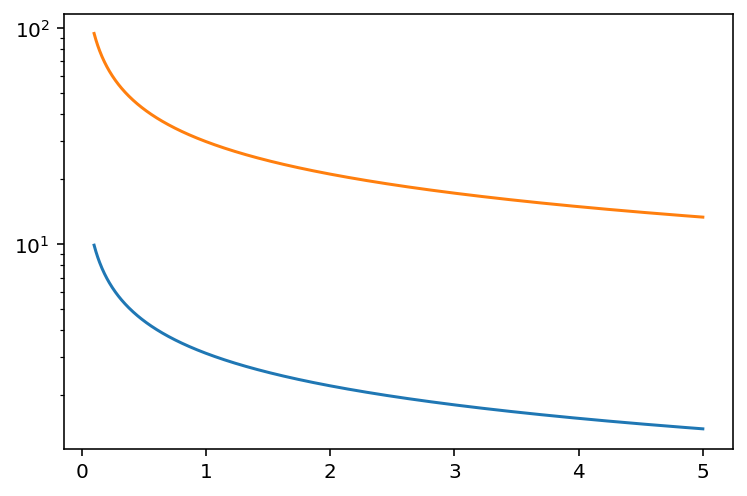

In [27]:
ap = np.linspace(0.1,5,1000)
ms1 = 1
mj = 1e-3
ms2 = 0.1
u = (ms1+mj)*ms2/(ms1+ms2+mj)
vc = np.sqrt(ms1*mj/ap/u)/KMS
vorb = np.sqrt(1/ap)/KMS
plt.plot(ap, vc)
plt.plot(ap,vorb)
plt.yscale('log')

30/4/np.pi/PC**2*(5*KMS)**2*PC**33

In [ ]:
def prograde(ip,ii):
    di = ii - ip
    di[di>np.pi]=di[di>np.pi]-2*np.pi

    return (-0.5*np.pi < di)&(di < 0.5*np.pi)

def retrograde(ip,ii):
    di = ii - ip
    di[di>np.pi]=di[di>np.pi]-2*np.pi

    return (-0.5*np.pi >= di)|(di >= 0.5*np.pi)

def show_obt_prop(name, dfs,a0s, df, a0, a_s=10):
    #cap = df['planet outcome'] == 'stay_{s1,j}'
    #a_c = df['a_{s1,j}']
    #e_c = df['e_{s1,j}']

    cap = df['planet outcome'] == 'stay_{sb,j}'#'stay_{s1,j}'
    a_c = df['a_{sb,j}']
    e_c = df['e_{sb,j}']
    cap = cap & (a_c[cap] < a_s/3.7)
   
    fig=plt.figure(figsize=(7.2, 3))
    
    ax = fig.add_subplot(1,2,1)
    ap_min = 10**(-0.5)
    ap_max = 10**(1.5)
    ax=sns.kdeplot(np.log10(a_c[cap]/AU), e_c[cap],clip=((np.log10(ap_min), np.log10(ap_max)),(0,1)), cmap='viridis',shade=True,cbar=True,cbar_kws={'label': 'KDE'})

    ap = 10**np.linspace(np.log10(ap_min), np.log10(ap_max),1000)
 
    ax.set_ylim([0,1])

    ax.set(xlabel='$\log_{10}(a_{\\rm p}^\prime/a_{\\rm p})$', ylabel='$e_{\\rm p}^\prime$')
    
    axa = fig.add_subplot(2,2,2)
    axe = fig.add_subplot(2,2,4)
    colors = cm.viridis(np.linspace(0,1,len(dfs)))

    for df, a0, color in zip(dfs,a0s,colors):
        #cap = df['planet outcome'] == 'stay_{s1,j}'
        #a_c = df['a_{s1,j}']
        #e_c = df['e_{s1,j}']
        #cap = cap & (a_c[cap] < 1000)

        cap = df['planet outcome'] == 'stay_{sb,j}'#'stay_{s1,j}'
        a_c = df['a_{sb,j}']
        e_c = df['e_{sb,j}']
        cap = cap & (a_c[cap] < a_s/3.7)
        
        vv,bb,cc=axa.hist(np.log10(a_c[cap]/a0),bins='auto',histtype='step',density=True,color=color,ls='-')
        #bc=0.5*(bb[0:-1]+bb[1::])
        #print(bc[vv==max(vv)])
        axa.hist(np.log10(a_c[cap]/a0),bins='auto',histtype='stepfilled',density=True,color=color,alpha=0.3,label='$a_{\\rm p}$='+str(a0)+'AU')
        
        axe.hist((e_c[cap]), bins='auto',histtype='step',density=True,color=color)
        axe.hist((e_c[cap]), bins='auto',histtype='stepfilled',density=True,alpha=0.3,color=color,label='$a_{\\rm p}$='+str(a0)+'AU')
        
   # axe.axvline(0.4356,ls='--',color='r',label='GJ 3512b')
    
    axe.set_xlabel('$e_{\\rm p}^\prime$')
    axe.set_ylabel('PDF')
    #axe.grid(True)
        
    #axa.axvline(np.log10(0.3380),ls='--',color='r',label='GJ 3512b')
    
    axa.set_xlabel('$\log_{10}(a_{\\rm p}^\prime/a_{\\rm p})$')
       
    axa.set_ylabel('PDF')
    #axa.grid(True)
    
    axe.legend(loc=2,fontsize=7,ncol=1,frameon=False, labelspacing=0,columnspacing =1)
    axa.legend(loc=1,fontsize=7,ncol=1,frameon=False, labelspacing=0,columnspacing =1)
    
    plt.tight_layout(h_pad=0,w_pad=0)
    
    savefig(plt,name)
    
show_obt_prop('itrans-bb-post-properties34',[df2, df1, df05],[2, 1, 0.5], df1, 1)

In [ ]:
def show_b(dfs,a_s, v=10.1*KMS):
    for df, a0 in zip(dfs, a_s):
        cap = df['planet outcome'] == 'stay_{s1,j}'
        a_c = df['a_{s1,j}']
        e_c = df['e_{s1,j}']
    
        obt_n = 'incident-orbit-'
    
        e = df[obt_n+'e']
        p = df[obt_n+'p']
        
        re = p/(1+e)
        
        b = p/np.sqrt(e**2-1)
    
        cap = cap & (a_c[cap] < 200)
        plt.hist(b[cap],bins='auto',histtype='step',density=True)
        plt.hist(b[cap],bins='auto',histtype='stepfilled',label='$a_p$='+str(a0)+'AU',density=True,alpha=0.8)
    plt.legend()
    plt.xlabel('$re_{ex}$ [AU]')
    plt.ylabel('PDF')
    plt.grid(True)
    savefig(plt,'explore_re')
    
    
show_b([df01,df05,df1,df2,df5],[0.1,0.5,1,2,5])

In [ ]:
def show_E(dfs,a_s, v_inf=10.1*KMS):
    
    num = len(dfs)
    fig =plt.figure(figsize=(4,3*num))
    
    axs=[]
    for i in range(num):
        axs.append(fig.add_subplot(num,1,i+1))
        
    for df, a0, ax in zip(dfs, a_s, axs):
        ms = df['m_{s}']
        mp = df['m_{j}']
        ms1=df['m_{s1}']
        
        v_tcm = v_inf*ms1/(ms1+ms+mp)
        
        v_scm = -v_tcm
        
        vs1 = v_inf - v_tcm
        
        Ekscm = 0.5*(ms+mp)*v_scm**2
        
        Eks1 = 0.5*ms1*vs1**2
        
        Eb = -G*ms*mp/2/a0
        
        vxs = df['vx_{s}']
        vys = df['vy_{s}']
        vzs = df['vz_{s}']
        
        vxs1 = df['vx_{s1}']
        vys1 = df['vy_{s1}']
        vzs1 = df['vz_{s1}']
        
        vxj = df['vx_{j}']
        vyj = df['vy_{j}']
        vzj = df['vz_{j}']
        
        vxcm = (vxs1*ms1 + vxj*mp)/(ms1+mp) 
        vycm = (vys1*ms1 + vyj*mp)/(ms1+mp) 
        vzcm = (vzs1*ms1 + vzj*mp)/(ms1+mp) 
        
        vcm = np.sqrt(vxcm**2 + vycm**2 + vzcm**2)
        
        
        
        vs = np.sqrt(vxs**2+vys**2+vzs**2)
        Eks = 0.5*ms*vs**2
        
        Eks1cm = 0.5*(ms1+mp)*vcm**2
        
        a_c = df['a_{s1,j}']
        e_c = df['e_{s1,j}']
        
        Eb_prime = -G*ms1*mp/2/a_c
        
        
        pxs = df['px_{s}']
        pys = df['py_{s}']
        pzs = df['pz_{s}']
        
        pxs1 = df['px_{s1}']
        pys1 = df['py_{s1}']
        pzs1 = df['pz_{s1}']
        
        pxj = df['px_{j}']
        pyj = df['py_{j}']
        pzj = df['pz_{j}']
        
        pxcm = (pxs1*ms1 + pxj*mp)/(ms1+mp) 
        pycm = (pys1*ms1 + pyj*mp)/(ms1+mp) 
        pzcm = (pzs1*ms1 + pzj*mp)/(ms1+mp) 
        
        dx = pxcm - pxs
        dy = pycm - pys
        dz = pzcm - pzs
        
        dr = np.sqrt(dx**2+dy**2+dz**2)
        
        Ep = -G*ms*(ms1+mp)/dr
        
        cap = df['planet outcome'] == 'stay_{s1,j}'
        
        obt_n = 'incident-orbit-'
    
        e = df[obt_n+'e']
        p = df[obt_n+'p']
        
        re = p/(1+e)
        
        b = p/np.sqrt(e**2-1)
    

        cap = cap & (a_c[cap] < 200)
        
        
        #plt.hist(Eks[cap],bins='auto',histtype='step',density=True)
        ax.plot(Eks[cap],label='$E_{s}$',color='orange')
        
        ax.plot(Eks1cm[cap],label='$E_{s1,cm}$',color='g')
        
        ax.plot(Eb_prime[cap],label='$B_{s1,cm}$',color='b')
        
        ax.plot(Ep[cap],label='$E_p$',color='r')
        
        
        
        ax.axhline(Ekscm[0],label='$E_{s,cm}$',color='orange',ls='--')
        ax.axhline(Eks1[0],label='$E_{s1}$',color='g',ls='--')
        ax.axhline(Eb[0],label='$B_{s,cm}$',color='b',ls='--')
        
        ax.legend()
        ax.set_xlabel('samples for'+'$a_p$='+str(a0)+'AU')
        ax.set_ylabel('Energy [?]')
        ax.set_xticklabels([])
        ax.grid(True)
        
    plt.tight_layout()
    savefig(plt,'explore_E')
    
    
show_E([df5,df2,df1,df05,df01],[5,2,1,0.5,0.1])

In [4]:
def integral_sigma(b_max, v_inf, N, type_mask, v_min, v_max, bin_num):

    dv = (v_max - v_min)/bin_num

    v = np.linspace(v_min, v_max, bin_num)

    sigma = 0
    for vv in v:
        mask = type_mask & (vv <= v_inf) & (v_inf < vv+dv)
        b = b_max[mask].mean()
        if np.isnan(b):
            b=0
        Nx = mask.sum()
        #print(b, Nx, vv)
        sigma += b**2 * Nx
    return sigma*np.pi / N
    

def v_dist_sigma(df, tp):
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    a = p/(1 - e**2)

    b = p / np.sqrt(e**2 - 1)

    v_inf = df['v_inf']

    b_max = df['b_max']
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'

    sigmas = {}

    v_min = 0
    v_max = 1.1*v_inf.max()
    b_num = 200

    if tp == 'ss':
        coll_ss = (sfate== 'coll_{s,s1}' )
        coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}')
    
        capture = pfate == 'stay_{s1,j}'

        sigmas.update({'ex':integral_sigma(b_max, v_inf, len(v_inf), capture, v_min, v_max, b_num)})
    elif tp == 'sb':
        coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,s2}' ) | (sfate== 'coll_{s1,s2}' )
        coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{s2,j}')

        s_capture = ( (pfate == 'stay_{s1,j}') & (sfate == 'disrupted') ) | ( (pfate == 'stay_{s2,j}') & (sfate == 'disrupted') )
    
        b_capture = ( (pfate == 'stay_{s1,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') )) | ( (pfate == 'stay_{s2,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') ))
        sigmas.update({'ex_s':integral_sigma(b_max, v_inf, len(v_inf), s_capture, v_min, v_max, b_num)})
        sigmas.update({'ex_b':integral_sigma(b_max, v_inf, len(v_inf), b_capture, v_min, v_max, b_num)})
    elif tp == 'bs':
        coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,sb}' ) | (sfate== 'coll_{s1,sb}' )
        coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{sb,j}')   

        capture = pfate == 'stay_{s1,j}'
    
        trans = pfate == 'stay_{sb,j}'
        sigmas.update({'ex':integral_sigma(b_max, v_inf, len(v_inf), capture, v_min, v_max, b_num)})
        sigmas.update({'trans':integral_sigma(b_max, v_inf, len(v_inf), trans, v_min, v_max, b_num)})
    elif tp == 'bb':
        coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,s2}' ) | (sfate== 'coll_{s1,s2}' ) | (sfate== 'coll_{s,sb}' ) | (sfate== 'coll_{sb,s1}' )| (sfate== 'coll_{sb,s2}' )
        coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{s2,j}')
    
        s_capture = ( (pfate == 'stay_{s1,j}') & (sfate == 'disrupted') ) | ( (pfate == 'stay_{s2,j}') & (sfate == 'disrupted') )
    
        b_capture = ( (pfate == 'stay_{s1,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') )) | ( (pfate == 'stay_{s2,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') ))
    
        trans = pfate == 'stay_{sb,j}'

        sigmas.update({'ex_s':integral_sigma(b_max, v_inf, len(v_inf), s_capture, v_min, v_max, b_num)})
        sigmas.update({'ex_b':integral_sigma(b_max, v_inf, len(v_inf), b_capture, v_min, v_max, b_num)})
        sigmas.update({'trans':integral_sigma(b_max, v_inf, len(v_inf), trans, v_min, v_max, b_num)})

    coll = coll_ss | coll_sj
    sigmas.update({'coll':integral_sigma(b_max, v_inf, len(v_inf), coll, v_min, v_max, b_num)})
    sigmas.update({'ej':integral_sigma(b_max, v_inf, len(v_inf), ej, v_min, v_max, b_num)})


    return sigmas

In [7]:


prefix = '../code/evn2/evn'

ext ='.txt'

evns =['_open_', '_globular_', '_field_']

tp = ['ss', 'sb', 'bs', 'bb']

names = [ss_names, sb_names, bs_names, bb_names]

idxs = [ss_idx, sb_idx, bs_idx, bb_idx]

pairs = [ss_pairs, sb_pairs, bs_pairs, bb_pairs]

evn_v = [1*KMS, 5*KMS, 30*KMS]

ajs = [1*AU, 0.1*AU, 1*AU]

stats = []
for evn, v, aj in zip(evns, evn_v, ajs):
    for t, name, idx, pair in zip(tp, names, idxs, pairs):
        fname = prefix + evn + t + ext
        print(fname)
        df = pd.DataFrame(post_process(fname, idx, name, pair))
                          
        
        s = v_dist_sigma(df, t)
        

        stats.append({evn+t:s})

../code/evn2/evn_open_ss.txt
/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in less
../code/evn2/evn_open_sb.txt
../code/evn2/evn_open_bs.txt
/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply
/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply
/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in multiply
/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
/

In [46]:
def trans_dic(dic):
    sigma = []
    if 'ex_s' in dic:
        sigma.append(dic['ex_s'])
    else:
        sigma.append(dic['ex'])

    if 'ex_b' in dic:
        sigma.append(dic['ex_b'])
    else:
        sigma.append(0)

    if 'trans' in dic:
        sigma.append(dic['trans'])
    else:
        sigma.append(0)

    sigma.append(dic['coll'])
    sigma.append(dic['ej'])

    return np.array(sigma)

def calc_rate(sigma,n,v):
    rate = np.copy(sigma)
    for i in range(12):
        evn_idx = int(i/4)
        rate[i,:]*=(n[evn_idx]*v[evn_idx]*np.sqrt( (3*np.pi - 8)/(3*np.pi) ))
    return  rate * (149597870700**2)/(3.0857e16)**3 * 1000 * 3600*24*365* 1e9  #rate/PC/PC/3.08e13 * 3600*24*365* 1e9 #1.4e10

def calc_n_vir(sigma, Mc, m =0.5):
    sigma = sigma * 1000 # to m/s
    v = sigma / np.sqrt( (3*np.pi - 8)/(3*np.pi) )
    print(v)
    G = 6.67e-11
    Ms = 1.98e30
    pc = 3.0857e16 
    return 6 * v**6/np.pi / G**3 / (Mc*Ms)**2 / (m*Ms) * pc**3

sigma =[]
for dic in stats:
    for key, v in dic.items():
        sigma.append(trans_dic(v))
sigma = np.array(sigma)

n_evn_low = calc_n_vir(np.array([1, 5, 30]), np.array([2000,45000,1]))
n_evn_low[2] = 1

#n_evn_high = calc_n_vir(np.array(evn_v)/KMS, np.array([1000,1e7,1]))
#n_evn_high[2] = 1
print(n_evn_low, n_evn_high)

rate = calc_rate(sigma, n_evn_low, [1, 5, 30])
#print(sigma, rate)
#[ex_s, ex_b, trans, coll, ej]

[ 2571.94673082 12859.7336541  77158.40192457]
[3.52558531e+03 1.08814361e+05 1.00000000e+00] [1.41023412e+04 2.20349082e+00 1.00000000e+00]


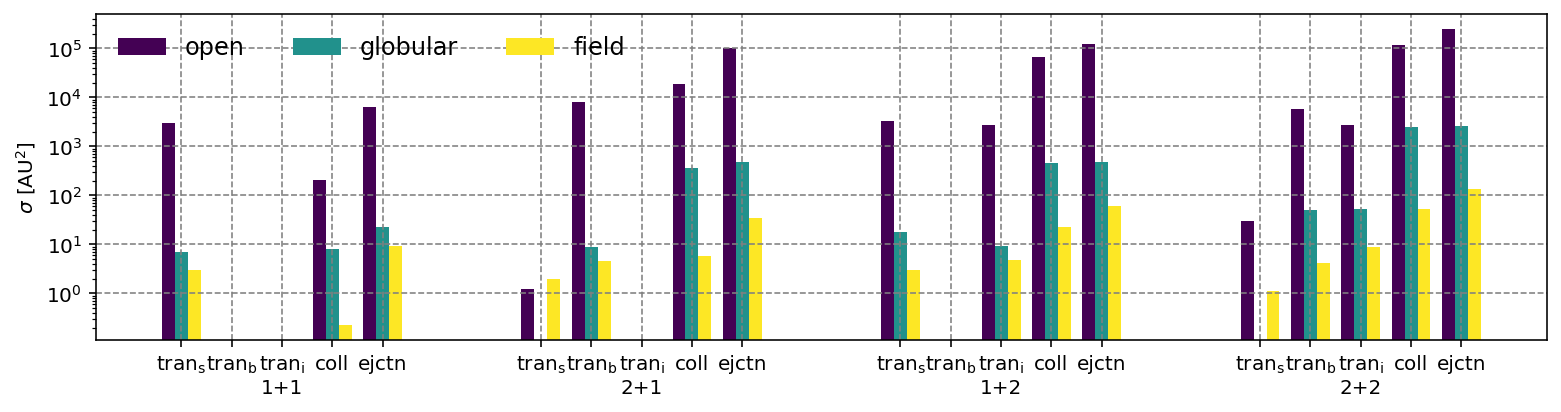

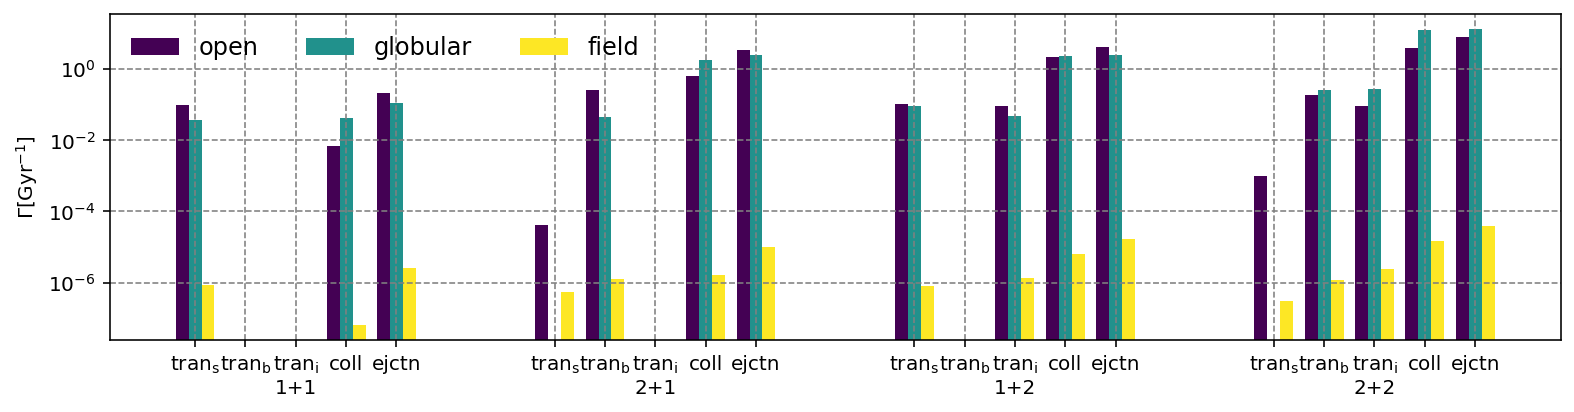

In [48]:
def draw_spectrum(sigma,name,ylabel):
    bar_width = 0.9
    type_range = 25
    group_width = 3.5
    bar_x = np.arange(3)*bar_width

    colors = cm.viridis(np.linspace(0, 1, 3))

    fig =plt.figure(figsize=(13,3))
    ax = fig.add_subplot(111)

    base = np.arange(5)*group_width
    colors = cm.viridis(np.linspace(0,1,3))
    labels=[['','open'],['','globular'],['','field']]
    for i in range(12):
        evn_idx = int(i/4)
        type_idx = i%4
        if evn_idx == 0 :
            ax.bar(base+evn_idx*bar_width + type_idx*type_range, sigma[i,:]/100,width=bar_width, color=colors[evn_idx],label=labels[evn_idx][int((type_idx+1)/4)])
        else:
            ax.bar(base+evn_idx*bar_width + type_idx*type_range, sigma[i,:],width=bar_width, color=colors[evn_idx],label=labels[evn_idx][int((type_idx+1)/4)])

    ax.set_yscale('log')
    ax.legend(frameon=False, ncol=3, fontsize=12)

    tick=[]
    for i in range(4):
        for j in range(5): 
            tick.append(i*type_range + j*group_width + bar_width)

    ax.set_xticks(tick)
    ax.set_xticklabels(['tran$_{\\rm s}$','tran$_{\\rm b}$','tran$_{\\rm i}$\n1+1','coll','ejctn', 'tran$_{\\rm s}$','tran$_{\\rm b}$','tran$_{\\rm i}$\n2+1','coll','ejctn', 'tran$_{\\rm s}$','tran$_{\\rm b}$','tran$_{\\rm i}$\n1+2','coll','ejctn', 'tran$_{\\rm s}$','tran$_{\\rm b}$','tran$_{\\rm i}$\n2+2','coll','ejctn' ])
    ax.grid(True)
    ax.set_ylabel(ylabel)
    savefig(plt,name)
draw_spectrum(sigma,'evn-cross-section','$\sigma$ [AU$^2]$')
draw_spectrum(rate,'evn-rate','$\Gamma [{\\rm Gyr}^{-1}]$')

ex_s, ex_b, trans, coll, ej

In [ ]:
def overall_sigma(sigma,fb):
    return 2*(1-fb)**2 * sigma[0] + 2*fb*(1-fb)*sigma[1] + fb*(1-fb)*sigma[2] + 4*fb**2*sigma[3]

def draw_overall_sigma(sigma):
    open_tran = sigma[0:4,0]+sigma[0:4,1]+sigma[0:4,2]
    open_coll = sigma[0:4,3]
    open_ej = sigma[0:4,4]

    g_tran = sigma[4:8,0]+sigma[4:8,1]+sigma[4:8,2]
    g_coll = sigma[4:8,3]
    g_ej = sigma[4:8,4]

    f_tran = sigma[8:12,0]+sigma[8:12,1]+sigma[8:12,2]
    f_coll = sigma[8:12,3]
    f_ej = sigma[8:12,4]

    fb = np.linspace(0,0.2,100)

    colors = cm.viridis(np.linspace(0,1,3))

    plt.plot(fb,overall_sigma(open_tran,fb),color=colors[0])
    plt.plot(fb,overall_sigma(open_coll,fb),color=colors[0],ls='--')
    plt.plot(fb,overall_sigma(open_ej,fb),color=colors[0],ls='-.')

    plt.plot(fb,overall_sigma(g_tran,fb),color=colors[1])
    plt.plot(fb,overall_sigma(g_coll,fb),color=colors[1],ls='--')
    plt.plot(fb,overall_sigma(g_ej,fb),color=colors[1],ls='-.')

    #plt.plot(fb,overall_sigma(f_tran,fb),color=colors[2])
    #plt.plot(fb,overall_sigma(f_coll,fb),color=colors[2],ls='--')
    #plt.plot(fb,overall_sigma(f_ej,fb),color=colors[2],ls='-.')

    plt.yscale('log')

draw_overall_sigma(rate)

In [ ]:
evn_ss_df = pd.read_csv('evn-ss.csv', skipinitialspace=True)
evn_bs_df = pd.read_csv('evn-bs.csv', skipinitialspace=True)
evn_sb_df = pd.read_csv('evn-sb.csv', skipinitialspace=True)
evn_bb_df = pd.read_csv('evn-bb.csv', skipinitialspace=True)

In [ ]:
prefix = '../code/ueq/ueq-normal-ss_ss_'

ss_idx = {'incident-orbit-s' : 40, 'incident-orbit-e':48, 'post-s':1, 'post-e':32}

ss_names = ['s','j', 's1']

ss_pairs = [('s','j'), ('s','s1'), ('s1','j')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        print(vv, aj)
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', ss_idx, ss_names, ss_pairs))
                          
        if df.empty != True:
            s = get_ss_final_data(df, float(vv), float(aj))
            stat.append(s)

In [ ]:
prefix = '../code/sb/dwarf-normal-sb_sb_'

sb_idx = {'incident-orbit-s' : 50, 'incident-orbit-e':58, 'post-s':1, 'post-e':42}

sb_names = ['s','j', 's1', 's2']

sb_pairs = [('s','j'), ('s','s1'),('s','s2'), ('s1','j'),('s2','j'),('s1','s2')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        print(vv, aj)
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', sb_idx, sb_names, sb_pairs))
        if df.empty != True:
            s = get_sb_final_data(df, float(vv), float(aj))
            stat.append(s)

In [ ]:
prefix = '../code/bs/dwarf-normal-bs_bs_'

bs_idx = {'incident-orbit-s' : 50, 'incident-orbit-e':58, 'post-s':1, 'post-e':42}

bs_names = ['s','sb', 'j', 's1']

bs_pairs = [('s','j'), ('s','s1'),('s','sb'), ('s1','j'),('sb','j'),('s1','sb')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        print(vv, aj)
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', bs_idx, bs_names, bs_pairs))
        if df.empty != True:
            s = get_bs_final_data(df, float(vv), float(aj))
            stat.append(s)
        
#df = pd.DataFrame(post_process(prefix+'0.1_0.1.txt', bs_idx, bs_names, bs_pairs))
#get_bs_final_data(df, float(vv), float(aj))

In [ ]:
prefix = '../code/bb/dwarf-normal-bb_bb_'

bb_idx = {'incident-orbit-s' : 60, 'incident-orbit-e':68, 'post-s':1, 'post-e':52}

bb_names = ['s','sb', 'j', 's1','s2']

bb_pairs = [('s','j'), ('s','s1'),('s','sb'), ('s1','j'),('sb','j'),('sb','s1'),('s','s2'),('s2','j'),('s1','s2'),('sb','s2')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        print(vv, aj)
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', bb_idx, bb_names, bb_pairs))
        if df.empty != True:
            s = get_bb_final_data(df, float(vv), float(aj))
            stat.append(s)


In [ ]:
def a_h(sigma, M):
    return G*M/sigma**2

a_h_02 = a_h(v_inf, 0.2)

a_p_max_02 = a_h_02 / stab_ratio

a_h_1 = a_h(v_inf, 1)

a_p_max_1 = a_h_1 / stab_ratio


plt.plot(v_inf/KMS, a_p_max_02/AU)
plt.axhline(5)
plt.axhline(0.1)
plt.xscale('log')
plt.yscale('log')

In [4]:
folder = 'modified/'
ssdf=pd.DataFrame(pd.read_csv(folder+'single-single.csv', skipinitialspace=True))
#dssdf=pd.DataFrame(pd.read_csv('solar/d-single-single.csv', skipinitialspace=True))

sbdf=pd.DataFrame(pd.read_csv(folder+'single-binary.csv',skipinitialspace=True))
#dsbdf=pd.DataFrame(pd.read_csv('solar/d-single-binary.csv',skipinitialspace=True))

bsdf=pd.DataFrame(pd.read_csv(folder+'binary-single.csv',skipinitialspace=True))
#dbsdf=pd.DataFrame(pd.read_csv('solar/d-binary-single.csv',skipinitialspace=True))

bbdf=pd.DataFrame(pd.read_csv(folder+'binary-binary.csv',skipinitialspace=True))
#dbbdf=pd.DataFrame(pd.read_csv('solar/d-binary-binary.csv',skipinitialspace=True))

In [5]:
ueqssdf = pd.DataFrame(pd.read_csv('solar/ueq-single-single.csv',skipinitialspace=True))

[92.7779749   2.03103674] [[ 5.46344865e+01 -2.55744339e-01]
 [-2.55744339e-01  1.19714259e-03]]


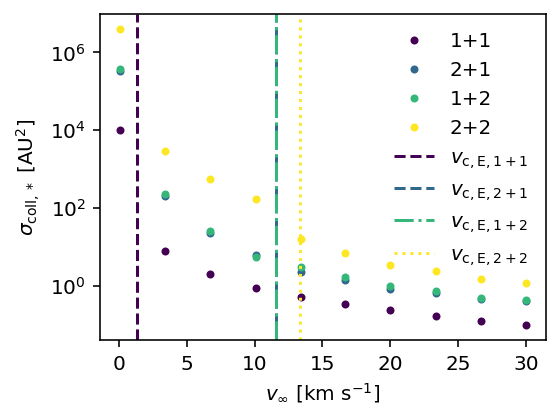

In [6]:
def fitting(x,a,b):
    return a/x**b

def logave(a,b,c,d):
    return 10** ((np.log10(a) + np.log10(b) + np.log10(c) + np.log10(d))/4)

    

f = coll_c
#ueqx ,ueqy, ueqe = end_c(ssdf)
ssx, ssy, sse=f(ssdf)
sbx, sby, sbe=f(sbdf)
bsx, bsy, bse=f(bsdf)
bbx, bby, bbe=f(bbdf)

#dssx, dssy, dsse = end_c(dssdf)
#dsbx, dsby, dsbe=end_c(dsbdf)
#dbsx, dbsy, dbse=end_c(dbsdf)
#dbbx, dbby, dbbe=end_c(dbbdf)

#ave_sy = logave(np.array(ssy), np.array(sby), np.array(bsy), np.array(bby))

#ave_dy = logave(np.array(dssy), np.array(dsby), np.array(dbsy), np.array(dbby))

fig=plt.figure(figsize=(4,3))

colors = cm.viridis(np.linspace(0,1,4))


plt.plot(ssx,ssy,'.',label='1+1',color=colors[0])
plt.plot(sbx,sby,'.',label='2+1',color=colors[1])
plt.plot(bsx,bsy,'.',label='1+2',color=colors[2])
plt.plot(bbx,bby,'.',label='2+2',color=colors[3])

#plt.plot(dssx,dssy,'x',label='dwarf 1+1')
#plt.plot(dsbx,dsby,'x',label='dwarf 2+1')
#plt.plot(dbsx,dbsy,'x',label='dwarf 1+2')
#plt.plot(dbbx,dbby,'x',label='dwarf 2+2')

a,b = optimize.curve_fit(fitting, ssx, ssy, p0=[10**4, 2], check_finite=True,absolute_sigma=True)

#a,b = optimize.curve_fit(fitting, ueqx, ueqy, p0=[10**4, 2], check_finite=True,absolute_sigma=True)

#da,db = optimize.curve_fit(fitting, dssx, ave_dy, p0=[0.2*10**4, 2], check_finite=True,absolute_sigma=True)

print(a,b)
v=np.linspace(0.1,30,1000)

#plt.plot(v, a[0]/v**a[1], 'k--', label='$\sim 1/v^{2.03}$')

#plt.plot(v, da[0]/v**da[1], 'k--')
ms = 1
ms1 = 1
ms2 = 1
mb = 1
mj =1e-3

a_s = 10
aj = 1

u11 = ms1*(ms+mj)/(ms1+ms+mj)
u12 = ms1*(ms+mb+mj)/(ms1+ms+mb+mj)
u21 = (ms1+ms2)*(ms+mj)/(ms1+ms+ms2+mj)
u22 = (ms1+ms2)*(ms+mb+mj)/(ms+mb+mj+ms1+ms2)

vc11 = np.sqrt(ms*mj/u11/aj)
vc12= np.sqrt(( ms*mj/aj + ms*mb/a_s )/u12)
vc21 = np.sqrt(( ms*mj/aj + ms1*ms2/a_s )/u21)
vc22= np.sqrt(( ms*mj/aj + ms1*ms2/a_s + ms*mb/a_s )/u22)

vj = np.sqrt((ms+mj)/aj)
vs = np.sqrt((ms+ms1)/a_s)

plt.axvline(vc11/KMS,ls='--',label='$v_{\\rm c, E,1+1}$',color=colors[0])
plt.axvline(vc21/KMS,ls='--',label='$v_{\\rm c, E,2+1}$',color=colors[1])
plt.axvline(vc12/KMS,ls='-.',label='$v_{\\rm c, E,1+2}$',color=colors[2])
plt.axvline(vc22/KMS,ls=':',label='$v_{\\rm c, E,2+2}$',color=colors[3])

plt.yscale('log')

#plt.xscale('log')
plt.legend(loc=1,ncol=1, frameon=False)
plt.xlabel('$v_\infty$ [km s$^{-1}$]')
plt.ylabel('$\sigma_{\\rm coll, *}$ [AU$^2$]')
#plt.grid(True)
savefig(plt,'cross-section-coll-s')

In [ ]:
np.sqrt(2/10)*30

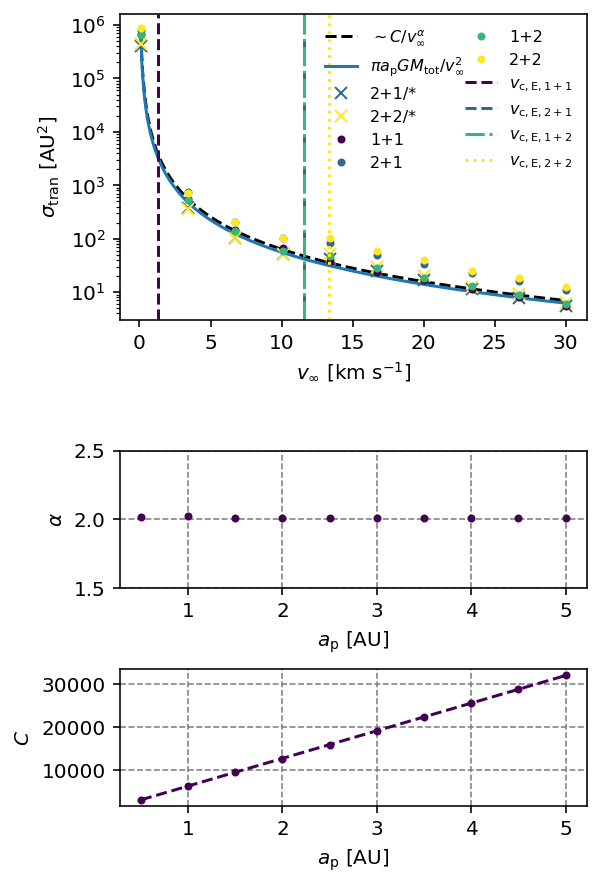

In [12]:

def ej_c(df,aj=1):
    N=1000000
    
    mask = df['aj']==aj
    
    x = df['vel'][mask]

    
    nx = N*df['ejection']
    er = np.sqrt(nx)/N
    y= (np.pi*df['b_max']**2*df['ejection'])[mask]
    err=(np.pi*df['b_max']**2*er)[mask]
    return x,y, err

def coll_c(df,aj=1):
    
    mask = df['aj']==aj
    
    N = len(mask)
    x = df['vel'][mask]

    ratio = df['s_coll']#+df['s_coll']

    nx = N*(ratio)
    er = np.sqrt(nx)/N
    y= (np.pi*df['b_max']**2*(ratio))[mask]
    err=(np.pi*df['b_max']**2*er)[mask]
    return x,y, err

def trans_c(df,aj=0):
    N=1000000
    
    mask = df['aj']==aj
    
    x = df['vel'][mask]

    
    nx = N*(df['trans'])
    er = np.sqrt(nx)/N
    y= (np.pi*df['b_max']**2*(df['trans']))[mask]
    err=(np.pi*df['b_max']**2*er)[mask]
    return x,y, err

def end_c(df,aj=2):
    N=1000000
    
    mask = df['aj']==aj
    
    x = df['vel'][mask]
    if 'cap' in df:
        nx = N*df['cap']
        er = np.sqrt(nx)/N
        y= (np.pi*df['b_max']**2*df['cap'])[mask]
        err=(np.pi*df['b_max']**2*er)[mask]
        return x,y, err
    else:
        nx = N* (df['b_cap']+df['s_cap'])
        er = np.sqrt(nx)/N
        y=(np.pi*df['b_max']**2*(df['b_cap']+df['s_cap']))[mask]
        err=(np.pi*df['b_max']**2*er)[mask]
        return x, y, err  

def show_fitting(ssdf,sbdf,bsdf,bbdf,a_s=10*AU, ms=1,ms1=1):
    fig = plt.figure(figsize=(4,6))
    ax = fig.add_subplot(2,1,1)
    
    ssx, ssy, sse=end_c(ssdf)
    sbx, sby, sbe=end_c(sbdf)
    bsx, bsy, bse=end_c(bsdf)
    bbx, bby, bbe=end_c(bbdf)

    colors = cm.viridis(np.linspace(0,1,4))
    

    ms = 1
    ms1 = 1
    ms2 = 1
    mb = 1
    mj =1e-3

    a_s = 10
    aj0 = 1

    u11 = ms1*(ms+mj)/(ms1+ms+mj)
    u12 = ms1*(ms+mb+mj)/(ms1+ms+mb+mj)
    u21 = (ms1+ms2)*(ms+mj)/(ms1+ms+ms2+mj)
    u22 = (ms1+ms2)*(ms+mb+mj)/(ms+mb+mj+ms1+ms2)

    vc11 = np.sqrt(ms*mj/u11/aj0)
    vc12= np.sqrt(( ms*mj/aj0 + ms*mb/a_s )/u12)
    vc21 = np.sqrt(( ms*mj/aj0 + ms1*ms2/a_s )/u21)
    vc22= np.sqrt(( ms*mj/aj0 + ms1*ms2/a_s + ms*mb/a_s )/u22)

    vj = np.sqrt((ms+mj)/aj0)
    vs = np.sqrt((ms+ms1)/a_s)
    
    

    a,b = optimize.curve_fit(fitting, ssx, ssy, p0=[10**4, 2], check_finite=True,absolute_sigma=True)
    
    
    v=np.linspace(0.1,30,1000)


    
    #ax.plot(v, a[0]/v**a[1],ls='-', lw=3,label='$\sim 1/v^{2.03}$',color='g',alpha=0.8)
    
    ax.plot(v, a[0]/v**a[1],ls='--',label='$\sim C/v_\infty^{\\alpha}$',color='k')

    asigma = 2*np.pi*(ms+mj)/(v*KMS)**2

    ax.plot(v,asigma,ls='-',label='$\pi a_{\\rm p}{GM_{\\rm tot}}/{v_\infty^2}$')


    ax.plot(sbx,sby/2,'x',label='2+1/*',color=colors[1])
    ax.plot(bbx,bby/2,'x',label='2+2/*',color=colors[3])
    
    ax.plot(ssx,ssy,'.',label='1+1',color=colors[0])
    ax.plot(sbx,sby,'.',label='2+1',color=colors[1])
    ax.plot(bsx,bsy,'.',label='1+2',color=colors[2])
    ax.plot(bbx,bby,'.',label='2+2',color=colors[3])

    #ax.axvline(np.sqrt((ms+ms1)/a_s)/KMS,ls='--',label='$v_{orbit}$',color='r')

    ax.axvline(vc11/KMS,ls='--',label='$v_{\\rm c, E,1+1}$',color=colors[0])
    ax.axvline(vc21/KMS,ls='--',label='$v_{\\rm c, E,2+1}$',color=colors[1])
    ax.axvline(vc12/KMS,ls='-.',label='$v_{\\rm c, E,1+2}$',color=colors[2])
    ax.axvline(vc22/KMS,ls=':',label='$v_{\\rm c, E,2+2}$',color=colors[3])
    ax.set_yscale('log')


    ax.legend(loc=1,ncol=2,frameon=False, fontsize=8,columnspacing=0)
    ax.set_xlabel('$v_\infty$ [km s$^{-1}$]')
    ax.set_ylabel('$\sigma_{\\rm tran}$ [AU$^2$]')

    #plt.grid(True)

    #savefig(plt,'cross-section-ejection')
    
    #return

    ax = fig.add_subplot(4,1,3)
    
    aj=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
    c=[]
    ec=[]
    p=[]
    ep=[]

    for a in aj:
    
        ssx ,ssy, sse = ej_c(ssdf,a)
    
        af,bf = optimize.curve_fit(fitting, ssx, ssy,p0=[10**4, 2])
        c.append(af[0])
        p.append(af[1])
        ec.append(bf[0][0])
        ep.append(bf[1][1])

     


    ax.plot(aj,p,'.',color=colors[0])    
    ax.set_ylim([1.5,2.5])
    #ax.set_xticks('')
    #ax.set_xticklabels('')
    ax.set_ylabel(r'$\alpha$')
    ax.set_xlabel('$a_{\\rm p}$ [AU]')
    ax.grid(True)
    
    ax=fig.add_subplot(4,1,4)
    ax.plot(aj,np.array(c),'.',color=colors[0])   
    fit_p=np.polyfit(aj,c,1)
    
    ax.plot(aj,(np.array(aj)*fit_p[0]+fit_p[1]),'--',color=colors[0])
    ax.set_xlabel('$a_{\\rm p}$ [AU]')
    ax.set_ylabel('$C$')
    
    plt.tight_layout(h_pad=0, w_pad=0,pad=0)
    plt.grid(True)

    #savefig(plt,'cross-section-fitting')
    
show_fitting(ssdf,sbdf, bsdf, bbdf)

In [ ]:
def v_c_1_1(ms, mj, aj, ms1):
    m_s = ms+mj
    m_i = ms1
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj))

def v_c_1_2(ms, mj, aj, ms1, ms2, a_s):
    m_s = ms+mj
    m_i = ms1+ms2
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj+ms1*ms2/a_s))

def v_c_2_1(ms, mb, mj, aj, ms1, a_s):
    m_s = ms+mj+mb
    m_i = ms1
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj + (ms+mj)*mb/a_s))

def v_c_2_2(ms, mb, mj, aj, ms1, ms2, a_s):
    m_s = ms+mj+mb
    m_i = ms1+ms2
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj + (ms+mj)*mb/a_s + ms1*ms2/a_s))


In [ ]:
v_c_1_1(1,1e-3,0.5,1)/KMS

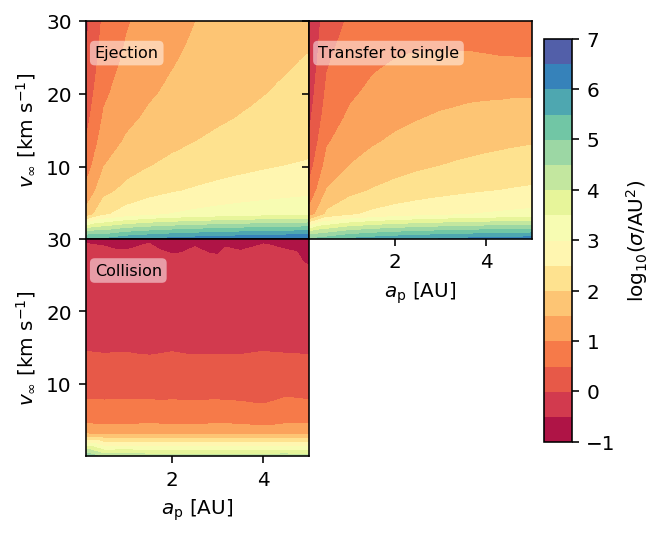

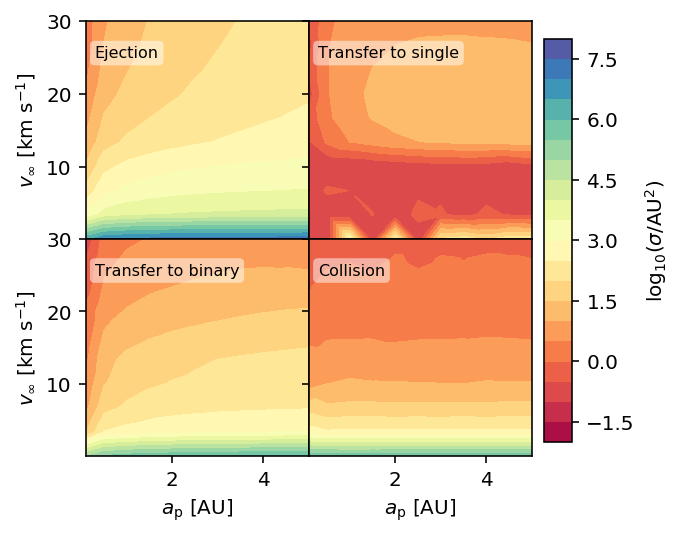

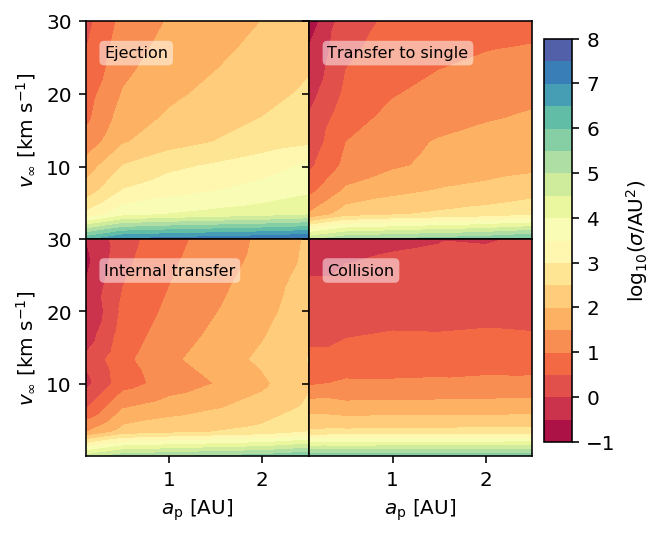

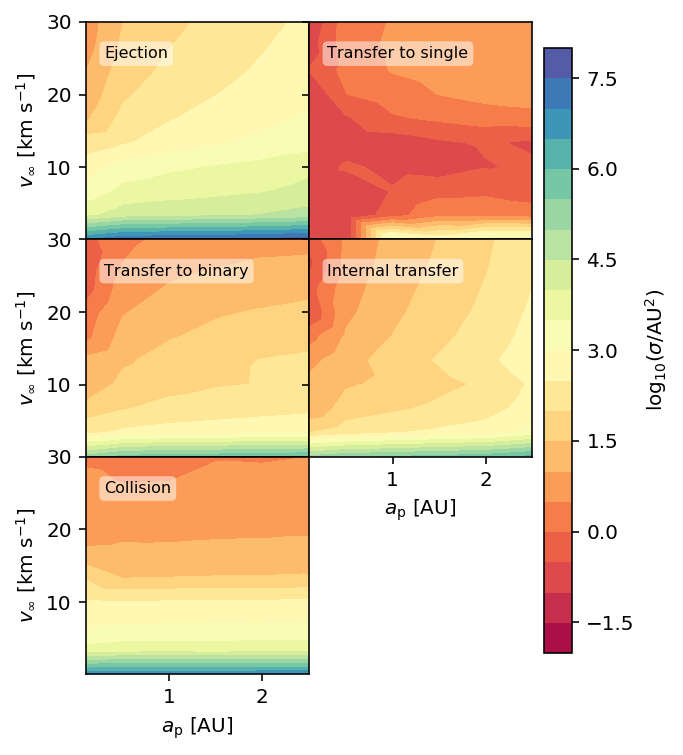

In [15]:
def event_title(e):
    if e == 'cap':
        return 'Transfer to single'
    elif e == 's_cap':
        return 'Transfer to single'
    elif e == 'b_cap':
        return 'Transfer to binary'
    elif e == 'coll':
        return 'Collision'
    elif e == 'trans':
        return 'Internal transfer'
    elif e == 'ejection':
        return 'Ejection'
    else:
        return e

def get_ratio(df, e):
    if e == 'coll':
        return np.array(df['s_coll']) +  np.array(df['s_coll'])
    else:
        return np.array(df[e])
    
def get_level(sigmas):
    max_s = 0
    min_s = 10**100
    for s in sigmas:
        max_s = max(max_s,s.max())
        min_s = min(min_s,s.min())
    
    if min_s > 0:
        min_s = int(min_s)
    else:
        min_s = int(min_s)-1
        
    if max_s > 0:
        max_s = int(max_s)+1
    else:
        max_s = int(max_s)
    return np.linspace(min_s, max_s, 2*max_s - 2*min_s+1)

def show_cross_section(name,df, event):
    x=np.array(df['aj'])
    y=(np.array(df['vel']))
    
    xlabel='$a_{\\rm p}$ [AU]'
    ylabel='$v_\infty$ [km s$^{-1}$]'
    
    delta = 1e-1
    
    C = np.array(df['b_max'])**2*np.pi
    
    labels = [event_title(e) for e in event]
    
    sigmas = [np.log10(C*get_ratio(df, e) + delta) for e in event]
        
    levels = get_level(sigmas)
  
    base_width = 2
    base_height= 2
    
    panel_num = len(event)
    
    row_num = int(((panel_num+1)/2))
    
    fig=plt.figure(figsize=(base_width*2, base_height*row_num))
    
    axs = [fig.add_subplot(row_num, 2, i+1) for i in range(panel_num)]
    
    for ax, sigma, label, i in zip(axs, sigmas, labels, range(panel_num)):
        im = ax.tricontourf(x,y, sigma, levels=levels, vmax=levels.max(), vmin=levels.min(),cmap='Spectral')
        
        ax.text(.3, 25, label,bbox=dict(facecolor='w', edgecolor='none', boxstyle='round',alpha=0.5),fontsize=8)
        #ax.text(.3, 25, label,fontsize=8)
        if i%2 == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_yticklabels('')
            
        if int(i/2) == row_num-1 or ((int(i/2) == row_num-2) and (i == panel_num - 2)):
            ax.set_xlabel(xlabel)
        else:
            ax.set_xticklabels('')
        #ax.grid(True)
      
    cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
    cb = plt.colorbar(im,cax=cbar_ax)
    cb.set_label('$\log_{10}(\sigma/$AU$^2)$') 
    
    plt.subplots_adjust(wspace=0, hspace=0)
    #plt.tight_layout(h_pad=0,w_pad=0)
    
    savefig(plt, name)
    
show_cross_section('solar-normal-ss',ssdf,['ejection','cap','coll'])
show_cross_section('solar-normal-sb',sbdf,['ejection','s_cap','b_cap','coll'])
show_cross_section('solar-normal-bs',bsdf,['ejection','cap','trans','coll'])
show_cross_section('solar-normal-bb',bbdf,['ejection','s_cap','b_cap','trans','coll'])
#show_cross_section('ueq-normal-ss',ueqssdf,['ejection','cap','coll'])